In [1]:
print("""
@Description: Using an External Dataset to Discover Sales Trends
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-08-14 14:34:08
""")


@Description: Using an External Dataset to Discover Sales Trends
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-08-14 14:34:08



In [18]:
import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')
from check_python_environment import check_packages
d = {
    'sqlalchemy': ['<', '2.0.0'],
    'pandas': ['>', '1.3.5'],
    'matplotlib': ['>', '3..0.0'],
    'psycopg2': ['>', '2.5.0']
}
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
check_packages(d)

[OK] sqlalchemy      1.4.32
[OK] pandas          1.4.2
[OK] matplotlib      3.5.1
[OK] psycopg2        2.9.7


In [7]:
cnxn_string = (
    'postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}')
print(cnxn_string)
engine = create_engine(
    cnxn_string.format(
        username='postgres',
        pswd='123456',
        host='localhost',
        port=5432,
        database='sql4da')
)

postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}


In [9]:
data = pd.read_csv(
    '../data/public_transportation_statistics_by_zip_code.csv',
    dtype={'zip_code': str}
)

In [10]:
import csv
from io import StringIO


def psql_insert_copy(table, conn, keys, data_iter):
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)
        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name
        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name,
            columns
        )
        cur.copy_expert(sql=sql, file=s_buf)

In [11]:
data.to_sql(
    'public_transportation_by_zip',
    engine,
    if_exists='replace',
    method=psql_insert_copy
)

In [12]:
data.max()

zip_code                            99929
public_transportation_pct           100.0
public_transportation_population    35139
dtype: object

In [13]:
data.min()

zip_code                                  00601
public_transportation_pct          -666666666.0
public_transportation_population              0
dtype: object

In [15]:
engine.execute("""
SELECT MAX(public_transportation_pct) AS max_pct,
       MIN(public_transportation_pct) AS min_pct
FROM public_transportation_by_zip;
""").fetchall()

[(100.0, -666666666.0)]

In [17]:
engine.execute("""
SELECT (public_transportation_pct > 10) AS is_high_public_transportation,
       COUNT(s.customer_id)*1.0/COUNT(DISTINCT c.customer_id) AS sales_per_customer
FROM customers AS c
INNER JOIN public_transportation_by_zip as t ON t.zip_code = c.postal_code
LEFT JOIN sales AS s ON s.customer_id = c.customer_id
WHERE t.public_transportation_pct > 0
GROUP BY 1
LIMIT 10;
""").fetchall()

[(False, Decimal('0.71703932151117964534')),
 (True, Decimal('0.83159379407616361072'))]

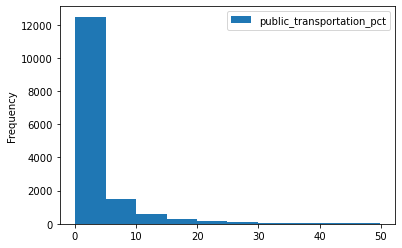

In [19]:
data = pd.read_sql_query("""
SELECT *
FROM public_transportation_by_zip
WHERE public_transportation_pct > 0
    AND public_transportation_pct < 50;
""", engine)
data.plot.hist(y='public_transportation_pct')
plt.show()

- Q5: Using pandas, test using the to_sql function with and without the method=psql_insert_COPY parameter. How do the speeds compare? (Hint: in a Jupyter notebook, you can add %time in front of your command to see how long it takes to execute the code.)

In [21]:
%time data.to_sql('public_transportation_by_zip', engine, if_exists='replace', method=psql_insert_copy)

CPU times: total: 62.5 ms
Wall time: 201 ms


In [22]:
%time data.to_sql('public_transportation_by_zip', engine, if_exists='replace')

CPU times: total: 328 ms
Wall time: 1.26 s


412

In [24]:
data = pd.read_sql_query("""
SELECT 10*ROUND(public_transportation_pct/10) AS public_transport,
       COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer
FROM customers AS c
INNER JOIN public_transportation_by_zip AS t ON t.zip_code = c.postal_code
LEFT JOIN sales AS s ON s.customer_id = c.customer_id
WHERE t.public_transportation_pct > 0
GROUP BY 1
""", engine)
data

,public_transport,sales_per_customer
0,0.0,0.715710
1,10.0,0.733236
2,20.0,0.811272
3,30.0,0.881288
4,40.0,0.755474
5,50.0,1.206349


In [25]:
data.to_csv('sales_vs_public_transport_pct.csv')